#Questão - 02

Realizar a comparação dos algoritmos K-NN, Janela de Parsen, Bayesiano Gaussiano e regressão logistica na base Image Segmentation data set.

- Realizar a tarefa de classificação da base de dados Image Segmentation (https://archive.ics.uci.edu/ml/datasets/Image+Segmentation) com os modelos K-NN, Bayesiano Gaussiano (com variáveis independentes), Bayesiano baseado em  janela de Parsen e Regressão logistica. 

# MEMBROS DA EQUIPE:

 
 

*   José Rafael de Santana
*   Lucas Geraldo Cilento
*   Mateus da Costa Silva Cabral


In [313]:
!pip install scikit-posthocs

In [314]:
import warnings
warnings.simplefilter("ignore", UserWarning)

#import the_module_that_warns

In [315]:
import urllib.request
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from scipy import stats
from sklearn.base import TransformerMixin, BaseEstimator, ClassifierMixin
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold,RepeatedStratifiedKFold
import scikit_posthocs as sp
import statsmodels.stats.api as sms
from scipy import stats
from sklearn.neighbors import KernelDensity



import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [316]:
raw_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.test", header=2)

In [317]:
raw_data

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
GRASS,110.0,189.0,9,0.000000,0.0,1.000000,0.666667,1.222222,1.186342,12.925926,10.888889,9.222222,18.666668,-6.111111,-11.111111,17.222221,18.666668,0.508139,1.910864
GRASS,86.0,187.0,9,0.000000,0.0,1.111111,0.720082,1.444444,0.750309,13.740741,11.666667,10.333334,19.222221,-6.222222,-10.222222,16.444445,19.222221,0.463329,1.941465
GRASS,225.0,244.0,9,0.000000,0.0,3.388889,2.195113,3.000000,1.520234,12.259259,10.333334,9.333334,17.111110,-5.777778,-8.777778,14.555555,17.111110,0.480149,1.987902
GRASS,47.0,232.0,9,0.000000,0.0,1.277778,1.254621,1.000000,0.894427,12.703704,11.000000,9.000000,18.111110,-5.111111,-11.111111,16.222221,18.111110,0.500966,1.875362
GRASS,97.0,186.0,9,0.000000,0.0,1.166667,0.691215,1.166667,1.005540,15.592592,13.888889,11.777778,21.111110,-5.111111,-11.444445,16.555555,21.111110,0.442661,1.863654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CEMENT,32.0,158.0,9,0.000000,0.0,0.944445,0.862963,0.833333,0.611111,7.962963,6.333334,11.888889,5.666666,-4.888889,11.777778,-6.888889,11.888889,0.520578,-1.982834
CEMENT,8.0,162.0,9,0.111111,0.0,1.611111,2.062962,0.333333,0.133333,8.370370,6.666666,12.000000,6.444445,-5.111111,10.888889,-5.777778,12.000000,0.484805,-2.044946
CEMENT,128.0,161.0,9,0.000000,0.0,0.555555,0.251852,0.777778,0.162963,7.148148,5.555555,10.888889,5.000000,-4.777778,11.222222,-6.444445,10.888889,0.540918,-1.996307
CEMENT,150.0,158.0,9,0.000000,0.0,2.166667,1.633334,1.388889,0.418518,8.444445,7.000000,12.222222,6.111111,-4.333334,11.333333,-7.000000,12.222222,0.503086,-1.943449


In [318]:
raw_data.reset_index(level=0, inplace=True)

In [319]:
raw_data.columns[0]

'index'

In [320]:
raw_data.rename(columns = {'index':'TARGET'}, inplace = True)

In [321]:
raw_data[raw_data['TARGET'] =='BRICKFACE']

,TARGET,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
1071,BRICKFACE,142.0,100.0,9,0.000000,0.0,0.666667,0.266666,1.388889,0.907407,22.222221,21.777779,28.444445,16.444445,-1.333333,18.666666,-17.333334,28.444445,0.421994,-1.623301
1072,BRICKFACE,27.0,50.0,9,0.000000,0.0,1.055556,0.462963,1.000000,0.488889,23.037037,21.666666,30.000000,17.444445,-4.111111,20.888890,-16.777779,30.000000,0.418746,-1.741254
1073,BRICKFACE,19.0,55.0,9,0.000000,0.0,1.444445,2.829630,1.277778,0.862964,21.037037,20.555555,26.666666,15.888889,-1.444444,16.888890,-15.444445,26.666666,0.404791,-1.634416
1074,BRICKFACE,34.0,83.0,9,0.000000,0.0,1.444445,0.340741,2.444445,0.429631,19.444445,19.555555,24.444445,14.333333,0.333333,15.000000,-15.333333,24.444445,0.410073,-1.507007
1075,BRICKFACE,82.0,109.0,9,0.111111,0.0,0.722223,0.240741,1.333334,0.800001,17.777779,19.222221,21.000000,13.111111,4.333334,9.666667,-14.000000,21.000000,0.376024,-1.276562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,BRICKFACE,177.0,126.0,9,0.000000,0.0,0.444444,0.118519,0.611111,0.418519,5.407407,7.666666,5.666666,2.888889,6.777778,0.777778,-7.555555,7.666666,0.623016,-0.612886
1900,BRICKFACE,108.0,111.0,9,0.000000,0.0,0.555555,0.162963,2.555555,0.385187,3.814815,4.111111,5.555555,1.777778,0.888889,5.222222,-6.111111,5.555555,0.715608,-1.437240
1901,BRICKFACE,146.0,124.0,9,0.000000,0.0,0.500000,0.166667,0.388889,0.107407,6.037037,7.444445,7.333334,3.333333,4.222222,3.888889,-8.111111,7.666666,0.563492,-1.024730
1902,BRICKFACE,39.0,111.0,9,0.000000,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


In [402]:
class DatasetConstructor(TransformerMixin, BaseEstimator):
    def __init__(self, db_type):
        self.db_type = db_type

    def transform(self, X):
        if self.db_type == 1:
          return X.iloc[:,list(range(4,9))]
        elif self.db_type == 2:
          return X.iloc[:,list(range(10,19))]
        elif self.db_type == 3:
          return X.iloc[:,list(range(4,19))]
        else:
          return X.iloc[:,list(range(1,19))]

    def fit(self, X, y=None):
        return self

In [403]:
scoring = ['accuracy','recall_macro','precision_macro','f1_macro']

In [324]:
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=24)
X = raw_data
y = raw_data['TARGET']


# EnsembleBayesianClassifier


This classifier recives 3 classifiers. 
  

*   Classifier_1 (clf_1): Used to fit and predict on variables 4 to 9 from original dataset 
*   Classifier_2 (clf_2): Used to fit and predict on variables 10 to 19 from original dataset
*   Classifier_3 (clf_3): Used to fit and predict on variables 4 to 19 from original dataset


  
  
These classifiers could be any classifier that follows scikit-learn standards. 

In [325]:
gaussian_pipe_1 = Pipeline([
('col_extract', DatasetConstructor( db_type=1 )), # Seleciona as features da base (4 a 9) e repassa para o classificador 1
('Gaussian_Bayesian_Classifier_1', GaussianNB())
])
gaussian_pipe_2 = Pipeline([
('col_extract', DatasetConstructor( db_type=2 )), # Seleciona as features da base (10 a 19) e repassa para o classificador 2
('Gaussian_Bayesian_Classifier_2', GaussianNB())
])
gaussian_pipe_3 = Pipeline([
('col_extract', DatasetConstructor( db_type=3 )),  # Seleciona as features da base (4 a 19) e repassa para o classificador 3
('Gaussian_Bayesian_Classifier_3', GaussianNB())
])




In [326]:
%%time
ensembled_gaussian_model = VotingClassifier(estimators=[('Gaussian_pipe_1', gaussian_pipe_1), ('Gaussian_pipe_2', gaussian_pipe_2), ('Gaussian_pipe_3', gaussian_pipe_3)], voting='hard')
bayesian_score = cross_validate(ensembled_gaussian_model, X=X, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)

CPU times: user 2.42 s, sys: 95.1 ms, total: 2.51 s
Wall time: 18.1 s


# EnsembleNearstNeiboursClassifier


This classifier recives 3 classifiers. 
  

*   Classifier_1 (clf_1): Used to fit and predict on variables 4 to 9 from original dataset 
*   Classifier_2 (clf_2): Used to fit and predict on variables 10 to 19 from original dataset
*   Classifier_3 (clf_3): Used to fit and predict on variables 4 to 19 from original dataset


In [327]:
K_values = list(range(1,30))

In [328]:
K_nn_pipe_1 = Pipeline([
('col_extract', DatasetConstructor( db_type=1 )), #  Seleciona as features da base (4 a 9) e repassa para o classificador 1
('K-nn_Bayesian_Classifier_1',  GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': K_values }, cv=inner_cv))
])
K_nn_pipe_2 = Pipeline([
('col_extract', DatasetConstructor( db_type=2 )), #  Seleciona as features da base (10 a 19) e repassa para o classificador 2
('K-nn_Bayesian_Classifier_2',  GridSearchCV(estimator=KNeighborsClassifier(),param_grid={'n_neighbors': K_values },cv=inner_cv))
])
K_nn_pipe_3 = Pipeline([
('col_extract', DatasetConstructor( db_type=3 )), #  Seleciona as features da base (4 a 19) e repassa para o classificador 3
('K-nn_Bayesian_Classifier_3',  GridSearchCV(estimator=KNeighborsClassifier(),param_grid={'n_neighbors': K_values },cv=inner_cv))
])


In [329]:
%%time
ensembled_K_nn_model = VotingClassifier(estimators=[('K_nn_pipe_1', K_nn_pipe_1), ('K_nn_pipe_2', K_nn_pipe_2), ('K_nn_pipe_3', K_nn_pipe_3)], voting='hard')
#clf = GridSearchCV(estimator=ensembled_K_nn_model, param_grid=p_grid, cv=inner_cv)
k_nn_score = cross_validate(ensembled_K_nn_model, X=X, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1,error_score='raise')

CPU times: user 19.1 s, sys: 1.88 s, total: 21 s
Wall time: 42min 27s


# EnsembleLogisticRegressionClassifier


This classifier recives 3 classifiers. 
  

*   Classifier_1 (clf_1): Used to fit and predict on variables 4 to 9 from original dataset 
*   Classifier_2 (clf_2): Used to fit and predict on variables 10 to 19 from original dataset
*   Classifier_3 (clf_3): Used to fit and predict on variables 4 to 19 from original dataset


  
  

In [330]:
C_values = list(range(1,30))

In [331]:
Logistic_Regression_pipe_1 = Pipeline([
('col_extract', DatasetConstructor( db_type=1 )), # Seleciona as features da base (4 a 9) e repassa para o classificador 1
('Logistic_Regression_Bayesian_Classifier_1',  LogisticRegression(solver='liblinear',multi_class='ovr',random_state=26) )
])
Logistic_Regression_pipe_2 = Pipeline([
('col_extract', DatasetConstructor( db_type=2 )), # Seleciona as features da base (10 a 19) e repassa para o classificador 2
('Logistic_Regression_Bayesian_Classifier_2',  LogisticRegression(solver='liblinear',multi_class='ovr',random_state=26) )
])
Logistic_Regression_pipe_3 = Pipeline([
('col_extract', DatasetConstructor( db_type=3 )), # Seleciona as features da base (4 a 19) e repassa para o classificador 3
('Logistic_Regression_Bayesian_Classifier_3',  LogisticRegression(solver='liblinear',multi_class='ovr',random_state=26) )
])

In [332]:
%%time

ensembled_LR_model = VotingClassifier(estimators=[('Gaussian_pipe_1', Logistic_Regression_pipe_1), ('Gaussian_pipe_2', Logistic_Regression_pipe_2), ('Gaussian_pipe_3', Logistic_Regression_pipe_3)], voting='hard')
LR_score = cross_validate(ensembled_LR_model, X=X, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)

CPU times: user 3.92 s, sys: 132 ms, total: 4.05 s
Wall time: 48.6 s


# EnsembleParzenWindowClassifier


This classifier recives 3 classifiers. 
  

*   Classifier_1 (clf_1): Used to fit and predict on variables 4 to 9 from original dataset 
*   Classifier_2 (clf_2): Used to fit and predict on variables 10 to 19 from original dataset
*   Classifier_3 (clf_3): Used to fit and predict on variables 4 to 19 from original dataset


  
  
These classifiers could be any classifier that follows scikit-learn standards. This ensemble classifier work only for image segmentation dataset (https://archive.ics.uci.edu/ml/datasets/Image+Segmentation)

In [333]:
import numpy as np
from scipy.special import gammainc

class DummyDensity(BaseEstimator):

    def __init__(self,a=None):
      self.a = a
    def fit(self, X, y=None):
        self.X_ = X
        return self

    def score_samples(self, X):   
        return np.zeros(len(X))

    def score(self, X, y=None):
        return np.sum(self.score_samples(X))

    

In [334]:
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_X_y,check_array,assert_all_finite
from sklearn.utils.multiclass import unique_labels


In [401]:
class ParzenWindowClassifier( BaseEstimator, ClassifierMixin ):

    def __init__(self,h=None, kernel='gaussian'):
      self.h = h
      self.kernel = kernel
      #self._estimator_type = "classifier"
      #if self.kernel not in ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']:
        #self.kernel = 'gaussian'

    def set_params(self, **parameters):
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self

    def get_params(self, deep=True):
      return {"h": self.h, "kernel": self.kernel}

    def fit(self, X, y=None):
      """
      Validação de entrada
      """
      assert_all_finite(X)
      check_array(X, force_all_finite='allow-nan',accept_sparse=False, accept_large_sparse=False)
      X, y = check_X_y(X, y, dtype=None, force_all_finite='allow-nan',multi_output=True, accept_sparse=False, accept_large_sparse=False)
      """
      Fim validação de entrada
      """
      self.classes_, y = np.unique(y, return_inverse=True)    #unique_labels(y)
      self.class_amount_ = len(self.classes_)
      self.X_ = X
      self.y_ = y
      self.n_features_in_ = X.shape[1]
      self.prior_ = None
      if self.y_.shape[0] != self.X_.shape[0]:
        msg = "Size of y does not match X size."
        raise ValueError(msg % (X.shape[1], self.X_.shape[1]))

        #self.class_proba_distributions_ = {}

      tmp = GaussianNB() # Usado apenas para definir a probabilidade a priori da classe, NÃO É USADO COMO CLASSIFICADOR NESSE CASO
      tmp.fit(self.X_,y)
      self.prior_ = tmp.class_prior_


      
      return self

    def predict_proba(self, X, y=None):
      """
      Validação de entrada
      """
      check_is_fitted(self)
      X = check_array(X, force_all_finite='allow-nan',accept_sparse=False, accept_large_sparse=False)
      assert_all_finite(X)
      if X.shape[1] != self.X_.shape[1]:
        msg = "Number of features %d does not match previous data %d."
        raise ValueError(msg % (X.shape[1], self.X_.shape[1]))

      if self.y_.shape[0] != self.X_.shape[0]:
        msg = "Size of y does not match X size."
        raise ValueError(msg % (X.shape[1], self.X_.shape[1]))
      """
      Fim validação de entrada
      """
      """
      Validação para garantir h != NULL
      """
      if self.h == None:
        h_not_null = 1
      else:
        h_not_null = self.h
      

      probabilities = np.zeros(len(X)*len(self.classes_)).reshape(len(X),len(self.classes_))# Inicializa matriz de probabilidade

      for i in range(0,self.class_amount_):
        class_examples_from_training_data = self.X_[self.y_ == self.classes_[i], :]
        target_class = self.classes_[i]

        if class_examples_from_training_data.size == 0:
          continue#kde = DummyDensity().fit(class_examples_from_training_data)
        else:
          kde = KernelDensity(kernel=self.kernel, bandwidth=h_not_null).fit(class_examples_from_training_data)
          probabilities[:,i] = np.exp(kde.score_samples(X))*self.prior_[i]     

      return probabilities

    def predict_log_proba(self, X, y=None):
      return np.log(self.predict_proba( X, y))

    def predict(self, X, y=None):
      """
      Validação de entrada
      """
      check_is_fitted(self)
      X = check_array(X, force_all_finite='allow-nan',accept_sparse=False, accept_large_sparse=False)
      assert_all_finite(X)
      """
      Fim validação de entrada
      """
          
      probabilities = self.predict_proba( X, y)
      return self.classes_[np.argmax(probabilities, axis=1)]#df_max.to_numpy().astype('U')



In [336]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(ParzenWindowClassifier())
 

In [337]:
H_values = np.logspace(-1, 1, 20)

In [338]:
Parzen_Window_pipe_1 = Pipeline([
('col_extract', DatasetConstructor( db_type=1 )), #  Seleciona as features da base (4 a 9) e repassa para o classificador 1
('Parzen_Window_Bayesian_Classifier_1',  GridSearchCV(estimator=ParzenWindowClassifier( kernel='gaussian'), param_grid={"h": H_values  }, scoring='accuracy', cv=inner_cv)) 
])
Parzen_Window_pipe_2 = Pipeline([
('col_extract', DatasetConstructor( db_type=2 )), #  Seleciona as features da base (10 a 19) e repassa para o classificador 2
('Parzen_Window_Bayesian_Classifier_2',  GridSearchCV(estimator=ParzenWindowClassifier( kernel='gaussian'), param_grid={"h": H_values  }, scoring='accuracy', cv=inner_cv)) 
])
Parzen_Window_pipe_3 = Pipeline([
('col_extract', DatasetConstructor( db_type=3 )), #  Seleciona as features da base (4 a 19) e repassa para o classificador 3
('Parzen_Window_Bayesian_Classifier_3',  GridSearchCV(estimator=ParzenWindowClassifier( kernel='gaussian'), param_grid={"h": H_values  }, scoring='accuracy', cv=inner_cv))
])


In [339]:
%%time
ensembled_Parzen_Window_model = VotingClassifier(estimators=[('Parzen_Window_pipe_1', Parzen_Window_pipe_1), ('Parzen_Window_pipe_2', Parzen_Window_pipe_2), ('Parzen_Window_pipe_3', Parzen_Window_pipe_3)], voting='hard')
Parzen_Window_score = cross_validate(ensembled_Parzen_Window_model, X=X, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1,error_score='raise')

CPU times: user 25.9 s, sys: 2.31 s, total: 28.2 s
Wall time: 56min 34s


# Análise estatística dos resultados

In [340]:
alpha = 0.05 # Significance of test interval

## Análise da acurácias

In [341]:
bayesian_accuracy = bayesian_score['test_accuracy']
k_nn_accuracy = k_nn_score['test_accuracy']
LR_accuracy = LR_score['test_accuracy']
Parzen_Window_accuracy = Parzen_Window_score['test_accuracy']
accuracies = np.concatenate((bayesian_accuracy.reshape(len(bayesian_accuracy),1), k_nn_accuracy.reshape(len(k_nn_accuracy),1), LR_accuracy.reshape(len(LR_accuracy),1), Parzen_Window_accuracy.reshape(len(Parzen_Window_accuracy),1)), axis=1)



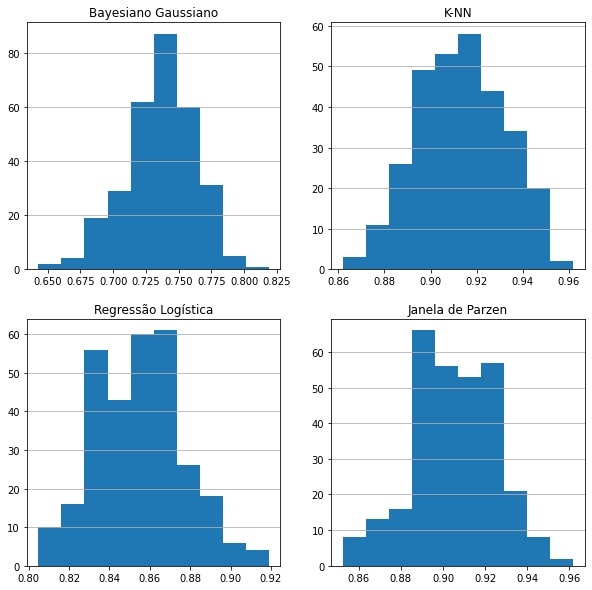

<Figure size 720x504 with 0 Axes>

In [394]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
fig = plt.figure(figsize =(10, 7))
fig.suptitle("Histogramas das Acurácias", fontsize=14)
axs[0, 0].hist(bayesian_accuracy)
axs[0, 0].set_title('Bayesiano Gaussiano')

axs[0, 0].yaxis.grid(True)
axs[0, 0]
bplot1 = axs[0, 0]
axs[0, 1].hist(k_nn_accuracy)
axs[0, 1].set_title('K-NN',)

axs[0, 1].yaxis.grid(True)
bplot2 = axs[0, 1]
axs[1, 0].hist(LR_accuracy)
axs[1, 0].set_title('Regressão Logística')

axs[1, 0].yaxis.grid(True)
bplot3 = axs[1, 0]
axs[1, 1].hist(Parzen_Window_accuracy)
axs[1, 1].set_title('Janela de Parzen')

axs[1, 1].yaxis.grid(True)
bplot4 = axs[1, 1]

fig.savefig(fname="Hist_Acuracies",  facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [343]:

bayesian_normal_test_accuracy = stats.normaltest(bayesian_accuracy, nan_policy='propagate')
k_nn_normal_test_accuracy = stats.normaltest(k_nn_accuracy, nan_policy='propagate')
LR_normal_test_accuracy = stats.normaltest(LR_accuracy, nan_policy='propagate')
Parzen_Window_normal_test_accuracy = stats.normaltest(Parzen_Window_accuracy, nan_policy='propagate')


print("H0:Is a Gaussian Distribution")
print("H1:Is NOT a Gaussian Distribution")
if bayesian_normal_test_accuracy.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for bayesian accuracy")
else:
    print("The null hypothesis cannot be rejected for bayesian accuracy")
if k_nn_normal_test_accuracy.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for k_nn accuracy")
else:
    print("The null hypothesis cannot be rejected for k_nn accuracy")
if LR_normal_test_accuracy.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for LR accuracy")
else:
    print("The null hypothesis cannot be rejected for LR accuracy")
if Parzen_Window_normal_test_accuracy.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for Parzen_Window accuracy")
else:
    print("The null hypothesis cannot be rejected for Parzen_Window accuracy")

H0:Is a Gaussian Distribution
H1:Is NOT a Gaussian Distribution
The null hypothesis can be rejected for bayesian accuracy
The null hypothesis cannot be rejected for k_nn accuracy
The null hypothesis cannot be rejected for LR accuracy
The null hypothesis cannot be rejected for Parzen_Window accuracy


In [344]:
bayesian_accuracy_confidence_interval = (np.mean(bayesian_accuracy),sms.DescrStatsW(bayesian_accuracy).tconfint_mean())
k_nn_accuracy_confidence_interval = (np.mean(k_nn_accuracy),sms.DescrStatsW(k_nn_accuracy).tconfint_mean())
LR_accuracy_confidence_interval = (np.mean(LR_accuracy),sms.DescrStatsW(LR_accuracy).tconfint_mean())
Parzen_Window_accuracy_confidence_interval = (np.mean(Parzen_Window_accuracy),sms.DescrStatsW(Parzen_Window_accuracy).tconfint_mean())
print("Bayesian Gaussian Classifier accuracy confidence Level: Mean={}, Lower/Upper bound={}".format(bayesian_accuracy_confidence_interval[0],bayesian_accuracy_confidence_interval[1]))
print("Bayesian K-NN Classifier accuracy confidence Level: Mean={}, Lower/Upper bound={}".format(k_nn_accuracy_confidence_interval[0],k_nn_accuracy_confidence_interval[1]))
print("Logistic Regression Classifier accuracy confidence Level: Mean={}, Lower/Upper bound={}".format(LR_accuracy_confidence_interval[0],LR_accuracy_confidence_interval[1]))
print("Bayesian Parzen_Window Classifier accuracy confidence Level: Mean={}, Lower/Upper bound={}".format(Parzen_Window_accuracy_confidence_interval[0],bayesian_accuracy_confidence_interval[1]))

Bayesian Gaussian Classifier accuracy confidence Level: Mean=0.736095238095238, Lower/Upper bound=(0.7331027302628178, 0.7390877459276582)
Bayesian K-NN Classifier accuracy confidence Level: Mean=0.9129523809523808, Lower/Upper bound=(0.9108824467952558, 0.9150223151095062)
Logistic Regression Classifier accuracy confidence Level: Mean=0.8545396825396824, Lower/Upper bound=(0.852107496024669, 0.8569718690546962)
Bayesian Parzen_Window Classifier accuracy confidence Level: Mean=0.9055714285714286, Lower/Upper bound=(0.7331027302628178, 0.7390877459276582)


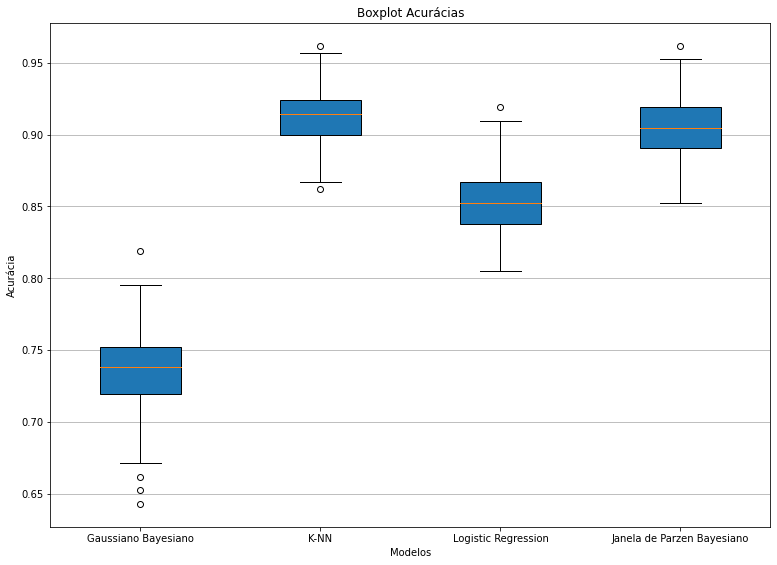

In [396]:
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp_accuracies = ax.boxplot(accuracies, labels=["Gaussiano Bayesiano", "K-NN", "Logistic Regression","Janela de Parzen Bayesiano"],patch_artist=True)
plt.title("Boxplot Acurácias")
plt.xlabel("Modelos")
plt.ylabel("Acurácia")
ax.yaxis.grid(True)
# show plot
#plt.setp(bp_accuracies, color='darkkhaki')
#ax.add_patch(facecolor=['darkkhaki', 'royalblue'])
plt.show()

fig.savefig(fname="Boxplot_Accuracies",  facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)


In [346]:
stats.friedmanchisquare(bayesian_accuracy,k_nn_accuracy,LR_accuracy,Parzen_Window_accuracy)

FriedmanchisquareResult(statistic=822.8234301147871, pvalue=4.856043828721881e-178)

## Análise das precisões

In [347]:
bayesian_precision = bayesian_score['test_precision_macro']
k_nn_precision = k_nn_score['test_precision_macro']
LR_precision = LR_score['test_precision_macro']
Parzen_Window_precision = Parzen_Window_score['test_precision_macro']
precisions = np.concatenate((bayesian_precision.reshape(len(bayesian_precision),1), k_nn_precision.reshape(len(k_nn_precision),1), LR_precision.reshape(len(LR_precision),1), Parzen_Window_precision.reshape(len(Parzen_Window_precision),1)), axis=1)


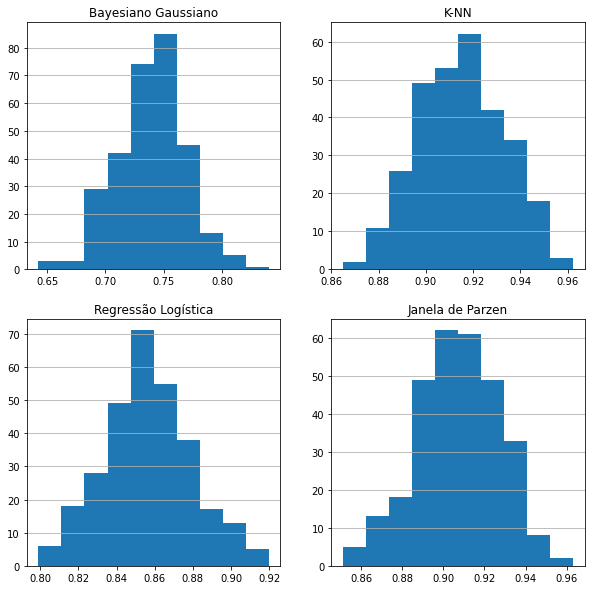

<Figure size 720x504 with 0 Axes>

In [348]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
fig = plt.figure(figsize =(10, 7))
fig.suptitle("Histogramas das precisões", fontsize=14)
axs[0, 0].hist(bayesian_precision)
axs[0, 0].set_title('Bayesiano Gaussiano')

axs[0, 0].yaxis.grid(True)
axs[0, 0]
bplot1 = axs[0, 0]
axs[0, 1].hist(k_nn_precision)
axs[0, 1].set_title('K-NN')

axs[0, 1].yaxis.grid(True)
bplot2 = axs[0, 1]
axs[1, 0].hist(LR_precision)
axs[1, 0].set_title('Regressão Logística')

axs[1, 0].yaxis.grid(True)
bplot3 = axs[1, 0]
axs[1, 1].hist(Parzen_Window_precision)
axs[1, 1].set_title('Janela de Parzen')

axs[1, 1].yaxis.grid(True)
bplot4 = axs[1, 1]

fig.savefig(fname="Hist_Precision",  facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [349]:
bayesian_normal_test_precision = stats.normaltest(bayesian_precision, nan_policy='propagate')
k_nn_normal_test_precision = stats.normaltest(k_nn_precision, nan_policy='propagate')
LR_normal_test_precision = stats.normaltest(LR_precision, nan_policy='propagate')
Parzen_Window_normal_test_precision = stats.normaltest(Parzen_Window_precision, nan_policy='propagate')


print("H0:Is a Gaussian Distribution")
print("H1:Is NOT a Gaussian Distribution")
if bayesian_normal_test_precision.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for bayesian precision")
else:
    print("The null hypothesis cannot be rejected for bayesian precision")
if k_nn_normal_test_precision.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for k_nn precision")
else:
    print("The null hypothesis cannot be rejected for k_nn precision")
if LR_normal_test_precision.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for LR precision")
else:
    print("The null hypothesis cannot be rejected for LR precision")
if Parzen_Window_normal_test_precision.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for Parzen_Window precision")
else:
    print("The null hypothesis cannot be rejected for Parzen_Window precision")

H0:Is a Gaussian Distribution
H1:Is NOT a Gaussian Distribution
The null hypothesis cannot be rejected for bayesian precision
The null hypothesis cannot be rejected for k_nn precision
The null hypothesis cannot be rejected for LR precision
The null hypothesis cannot be rejected for Parzen_Window precision


In [350]:
bayesian_precision_confidence_interval = (np.mean(bayesian_precision),sms.DescrStatsW(bayesian_precision).tconfint_mean())
k_nn_precision_confidence_interval = (np.mean(k_nn_precision),sms.DescrStatsW(k_nn_precision).tconfint_mean())
LR_precision_confidence_interval = (np.mean(LR_precision),sms.DescrStatsW(LR_precision).tconfint_mean())
Parzen_Window_precision_confidence_interval = (np.mean(Parzen_Window_precision),sms.DescrStatsW(Parzen_Window_precision).tconfint_mean())
print("Bayesian Gaussian Classifier precision confidence Level: Mean={}, Lower/Upper bound={}".format(bayesian_precision_confidence_interval[0],bayesian_precision_confidence_interval[1]))
print("Bayesian K-NN Classifier precision confidence Level: Mean={}, Lower/Upper bound={}".format(k_nn_precision_confidence_interval[0],k_nn_precision_confidence_interval[1]))
print("Logistic Regression Classifier precision confidence Level: Mean={}, Lower/Upper bound={}".format(LR_precision_confidence_interval[0],LR_precision_confidence_interval[1]))
print("Bayesian Parzen_Window Classifier precision confidence Level: Mean={}, Lower/Upper bound={}".format(Parzen_Window_precision_confidence_interval[0],bayesian_precision_confidence_interval[1]))

Bayesian Gaussian Classifier precision confidence Level: Mean=0.7391558387608368, Lower/Upper bound=(0.7358139171627979, 0.7424977603588759)
Bayesian K-NN Classifier precision confidence Level: Mean=0.9145700737841884, Lower/Upper bound=(0.9124768709626115, 0.9166632766057649)
Logistic Regression Classifier precision confidence Level: Mean=0.8564742914525897, Lower/Upper bound=(0.8538785236607076, 0.8590700592444718)
Bayesian Parzen_Window Classifier precision confidence Level: Mean=0.9073525820520574, Lower/Upper bound=(0.7358139171627979, 0.7424977603588759)


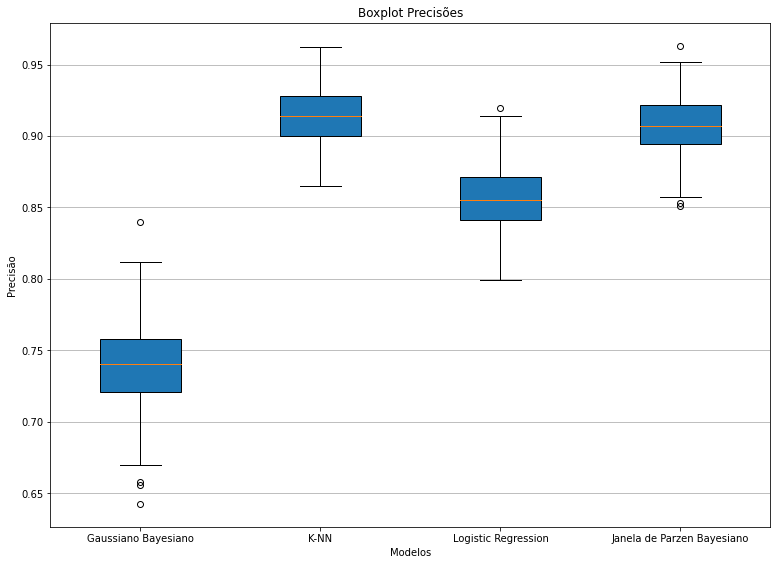

In [397]:
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp_precisions = ax.boxplot(precisions, labels=["Gaussiano Bayesiano", "K-NN", "Logistic Regression","Janela de Parzen Bayesiano"],patch_artist=True)
plt.title("Boxplot Precisões")
plt.xlabel("Modelos")
plt.ylabel("Precisão")
ax.yaxis.grid(True)
# show plot
plt.show()


fig.savefig(fname="Boxplot_Precisions",  facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [352]:
stats.friedmanchisquare(bayesian_precision,k_nn_precision,LR_precision,Parzen_Window_precision)

FriedmanchisquareResult(statistic=811.027342447483, pvalue=1.7564773773846643e-175)

## Análise das coberturas

In [353]:
bayesian_recall = bayesian_score['test_recall_macro']
k_nn_recall = k_nn_score['test_recall_macro']
LR_recall = LR_score['test_recall_macro']
Parzen_Window_recall = Parzen_Window_score['test_recall_macro']
recalls = np.concatenate((bayesian_recall.reshape(len(bayesian_recall),1), k_nn_recall.reshape(len(k_nn_recall),1), LR_recall.reshape(len(LR_recall),1), Parzen_Window_recall.reshape(len(Parzen_Window_recall),1)), axis=1)


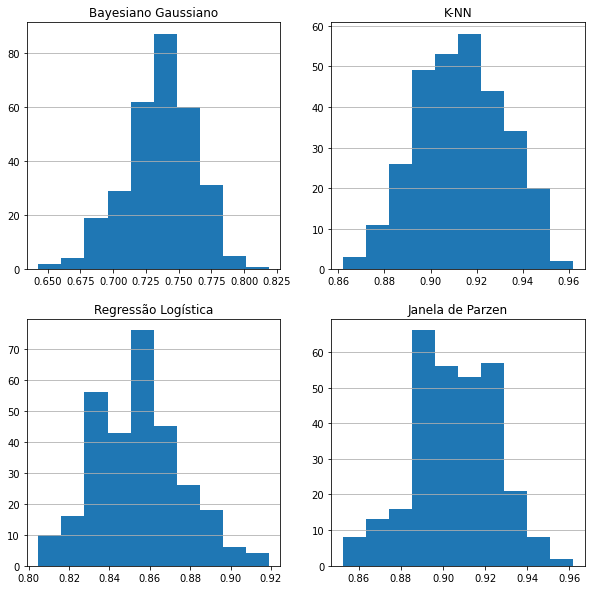

<Figure size 720x504 with 0 Axes>

In [354]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
fig = plt.figure(figsize =(10, 7))
fig.suptitle("Histogramas das Coberturas", fontsize=14)
axs[0, 0].hist(bayesian_recall)
axs[0, 0].set_title('Bayesiano Gaussiano')

axs[0, 0].yaxis.grid(True)
axs[0, 0]
bplot1 = axs[0, 0]
axs[0, 1].hist(k_nn_recall)
axs[0, 1].set_title('K-NN')

axs[0, 1].yaxis.grid(True)
bplot2 = axs[0, 1]
axs[1, 0].hist(LR_recall)
axs[1, 0].set_title('Regressão Logística')

axs[1, 0].yaxis.grid(True)
bplot3 = axs[1, 0]
axs[1, 1].hist(Parzen_Window_recall)
axs[1, 1].set_title('Janela de Parzen')

axs[1, 1].yaxis.grid(True)
bplot4 = axs[1, 1]

fig.savefig(fname="Hist_Recall",  facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [355]:
bayesian_normal_test_recall = stats.normaltest(bayesian_recall, nan_policy='propagate')
k_nn_normal_test_recall = stats.normaltest(k_nn_recall, nan_policy='propagate')
LR_normal_test_recall = stats.normaltest(LR_recall, nan_policy='propagate')
Parzen_Window_normal_test_recall = stats.normaltest(Parzen_Window_recall, nan_policy='propagate')


print("H0:Is a Gaussian Distribution")
print("H1:Is NOT a Gaussian Distribution")
if bayesian_normal_test_recall.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for bayesian recall")
else:
    print("The null hypothesis cannot be rejected for bayesian recall")
if k_nn_normal_test_recall.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for k_nn recall")
else:
    print("The null hypothesis cannot be rejected for k_nn recall")
if LR_normal_test_recall.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for LR recall")
else:
    print("The null hypothesis cannot be rejected for LR recall")
if Parzen_Window_normal_test_recall.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for Parzen_Window recall")
else:
    print("The null hypothesis cannot be rejected for Parzen_Window recall")

H0:Is a Gaussian Distribution
H1:Is NOT a Gaussian Distribution
The null hypothesis can be rejected for bayesian recall
The null hypothesis cannot be rejected for k_nn recall
The null hypothesis cannot be rejected for LR recall
The null hypothesis cannot be rejected for Parzen_Window recall


In [356]:
bayesian_recall_confidence_interval = (np.mean(bayesian_recall),sms.DescrStatsW(bayesian_recall).tconfint_mean())
k_nn_recall_confidence_interval = (np.mean(k_nn_recall),sms.DescrStatsW(k_nn_recall).tconfint_mean())
LR_recall_confidence_interval = (np.mean(LR_recall),sms.DescrStatsW(LR_recall).tconfint_mean())
Parzen_Window_recall_confidence_interval = (np.mean(Parzen_Window_recall),sms.DescrStatsW(Parzen_Window_recall).tconfint_mean())
print("Bayesian Gaussian Classifier recall confidence Level: Mean={}, Lower/Upper bound={}".format(bayesian_recall_confidence_interval[0],bayesian_recall_confidence_interval[1]))
print("Bayesian K-NN Classifier recall confidence Level: Mean={}, Lower/Upper bound={}".format(k_nn_recall_confidence_interval[0],k_nn_recall_confidence_interval[1]))
print("Logistic Regression Classifier recall confidence Level: Mean={}, Lower/Upper bound={}".format(LR_recall_confidence_interval[0],LR_recall_confidence_interval[1]))
print("Bayesian Parzen_Window Classifier recall confidence Level: Mean={}, Lower/Upper bound={}".format(Parzen_Window_recall_confidence_interval[0],bayesian_recall_confidence_interval[1]))

Bayesian Gaussian Classifier recall confidence Level: Mean=0.736095238095238, Lower/Upper bound=(0.7331027302628178, 0.7390877459276582)
Bayesian K-NN Classifier recall confidence Level: Mean=0.9129523809523808, Lower/Upper bound=(0.9108824467952558, 0.9150223151095062)
Logistic Regression Classifier recall confidence Level: Mean=0.8545396825396824, Lower/Upper bound=(0.852107496024669, 0.8569718690546962)
Bayesian Parzen_Window Classifier recall confidence Level: Mean=0.9055714285714286, Lower/Upper bound=(0.7331027302628178, 0.7390877459276582)


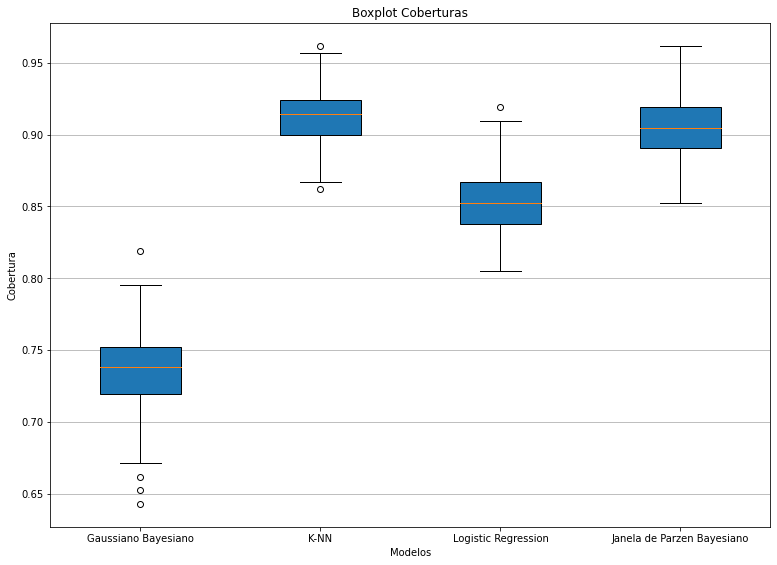

In [398]:
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp_recalls = ax.boxplot(recalls, labels=["Gaussiano Bayesiano", "K-NN", "Logistic Regression","Janela de Parzen Bayesiano"],patch_artist=True)
plt.title("Boxplot Coberturas")
plt.xlabel("Modelos")
plt.ylabel("Cobertura")
ax.yaxis.grid(True)
# show plot
plt.show()

fig.savefig(fname="Boxplot_Recalls",  facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [358]:
stats.friedmanchisquare(bayesian_recall,k_nn_recall,LR_recall,Parzen_Window_recall)

FriedmanchisquareResult(statistic=820.7755308392318, pvalue=1.3503254805485892e-177)

## Análise das F-measures

In [359]:
bayesian_f1 = bayesian_score['test_f1_macro']
k_nn_f1 = k_nn_score['test_f1_macro']
LR_f1 = LR_score['test_f1_macro']
Parzen_Window_f1 = Parzen_Window_score['test_f1_macro']
f1_scores = np.concatenate((bayesian_f1.reshape(len(bayesian_f1),1), k_nn_f1.reshape(len(k_nn_f1),1), LR_f1.reshape(len(LR_f1),1), Parzen_Window_f1.reshape(len(Parzen_Window_f1),1)), axis=1)


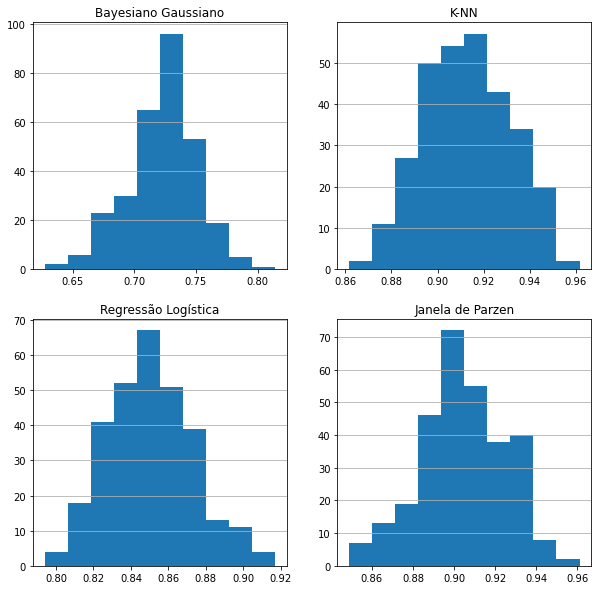

<Figure size 720x504 with 0 Axes>

In [360]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
fig = plt.figure(figsize =(10, 7))
fig.suptitle("Histogramas das F-Measures", fontsize=14)
axs[0, 0].hist(bayesian_f1)
axs[0, 0].set_title('Bayesiano Gaussiano')

axs[0, 0].yaxis.grid(True)
axs[0, 0]
bplot1 = axs[0, 0]
axs[0, 1].hist(k_nn_f1)
axs[0, 1].set_title('K-NN')

axs[0, 1].yaxis.grid(True)
bplot2 = axs[0, 1]
axs[1, 0].hist(LR_f1)
axs[1, 0].set_title('Regressão Logística')

axs[1, 0].yaxis.grid(True)
bplot3 = axs[1, 0]
axs[1, 1].hist(Parzen_Window_f1)
axs[1, 1].set_title('Janela de Parzen')

axs[1, 1].yaxis.grid(True)
bplot4 = axs[1, 1]

fig.savefig(fname="Hist_F_Measures",  facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [361]:
bayesian_normal_test_f1 = stats.normaltest(bayesian_f1, nan_policy='propagate')
k_nn_normal_test_f1 = stats.normaltest(k_nn_f1, nan_policy='propagate')
LR_normal_test_f1 = stats.normaltest(LR_f1, nan_policy='propagate')
Parzen_Window_normal_test_f1 = stats.normaltest(Parzen_Window_f1, nan_policy='propagate')


print("H0:Is a Gaussian Distribution")
print("H1:Is NOT a Gaussian Distribution")
if bayesian_normal_test_f1.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for bayesian f1")
else:
    print("The null hypothesis cannot be rejected for bayesian f1")
if k_nn_normal_test_f1.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for k_nn f1")
else:
    print("The null hypothesis cannot be rejected for k_nn f1")
if LR_normal_test_f1.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for LR f1")
else:
    print("The null hypothesis cannot be rejected for LR f1")
if Parzen_Window_normal_test_f1.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected for Parzen_Window f1")
else:
    print("The null hypothesis cannot be rejected for Parzen_Window f1")

H0:Is a Gaussian Distribution
H1:Is NOT a Gaussian Distribution
The null hypothesis can be rejected for bayesian f1
The null hypothesis cannot be rejected for k_nn f1
The null hypothesis cannot be rejected for LR f1
The null hypothesis cannot be rejected for Parzen_Window f1


In [406]:
bayesian_f1_confidence_interval = (np.mean(bayesian_f1),sms.DescrStatsW(bayesian_f1).tconfint_mean())
k_nn_f1_confidence_interval = (np.mean(k_nn_f1),sms.DescrStatsW(k_nn_f1).tconfint_mean())
LR_f1_confidence_interval = (np.mean(LR_f1),sms.DescrStatsW(LR_f1).tconfint_mean())
Parzen_Window_f1_confidence_interval = (np.mean(Parzen_Window_f1),sms.DescrStatsW(Parzen_Window_f1).tconfint_mean())
print("Bayesian Gaussian Classifier f1 confidence Level: Mean={}, Lower/Upper bound={}".format(bayesian_f1_confidence_interval[0],bayesian_f1_confidence_interval[1]))
print("Bayesian K-NN Classifier f1 confidence Level: Mean={}, Lower/Upper bound={}".format(k_nn_f1_confidence_interval[0],k_nn_f1_confidence_interval[1]))
print("Logistic Regression Classifier f1 confidence Level: Mean={}, Lower/Upper bound={}".format(LR_f1_confidence_interval[0],LR_f1_confidence_interval[1]))
print("Bayesian Parzen_Window Classifier f1 confidence Level: Mean={}, Lower/Upper bound={}".format(Parzen_Window_f1_confidence_interval[0],bayesian_f1_confidence_interval[1]))

Bayesian Gaussian Classifier f1 confidence Level: Mean=0.7225937317609945, Lower/Upper bound=(0.7193758033448324, 0.7258116601771566)
Bayesian K-NN Classifier f1 confidence Level: Mean=0.912227733516624, Lower/Upper bound=(0.9101307296158653, 0.9143247374173818)
Logistic Regression Classifier f1 confidence Level: Mean=0.8502915175740261, Lower/Upper bound=(0.8477348801888595, 0.8528481549591928)
Bayesian Parzen_Window Classifier f1 confidence Level: Mean=0.9047299213263872, Lower/Upper bound=(0.7193758033448324, 0.7258116601771566)


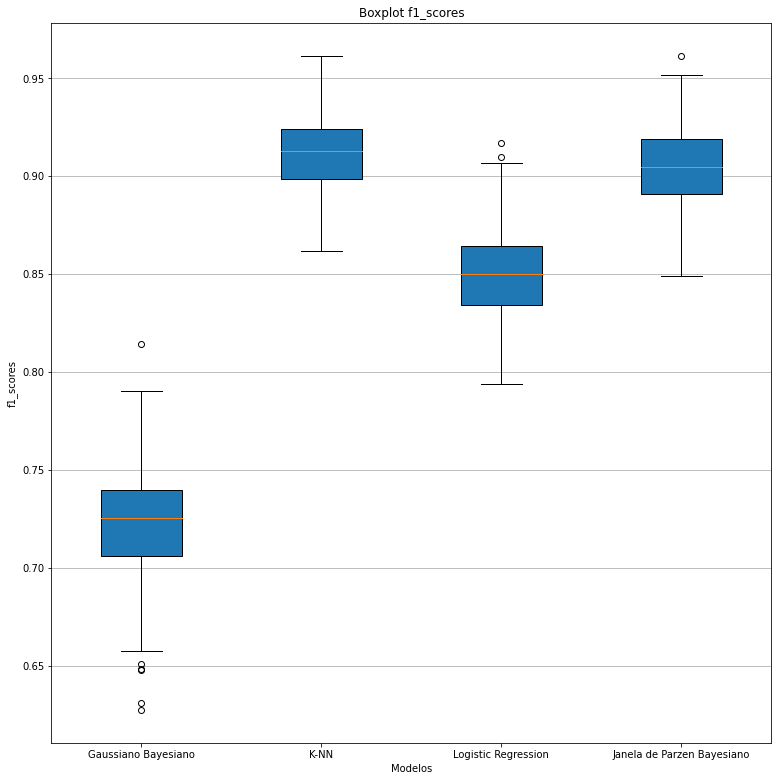

In [407]:
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure(figsize =(10, 10))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp_f1_scores = ax.boxplot(f1_scores, labels=["Gaussiano Bayesiano", "K-NN", "Logistic Regression","Janela de Parzen Bayesiano"],patch_artist=True)
plt.title("Boxplot f1_scores")
plt.xlabel("Modelos")
plt.ylabel("f1_scores")
ax.yaxis.grid(True)
# show plot
plt.show()


fig.savefig(fname="Boxplot_F1",  facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [364]:
stats.friedmanchisquare(bayesian_f1,k_nn_f1,LR_f1,Parzen_Window_f1)

FriedmanchisquareResult(statistic=814.1443814604874, pvalue=3.7035402034142986e-176)

# Pós Teste

## Acurácia:

In [365]:
data = np.array([bayesian_accuracy, k_nn_accuracy, LR_accuracy, Parzen_Window_accuracy])
sp.posthoc_nemenyi_friedman(data.T)

,0,1,2,3
0,1.000,0.00100,0.001,0.00100
1,0.001,1.00000,0.001,0.00268
2,0.001,0.00100,1.000,0.00100
3,0.001,0.00268,0.001,1.00000


## Precisão:

In [366]:
data = np.array([bayesian_precision, k_nn_precision, LR_precision, Parzen_Window_precision])
sp.posthoc_nemenyi_friedman(data.T)

,0,1,2,3
0,1.000,0.00100,0.001,0.00100
1,0.001,1.00000,0.001,0.00399
2,0.001,0.00100,1.000,0.00100
3,0.001,0.00399,0.001,1.00000


## Cobertura:

In [367]:
data = np.array([bayesian_recall, k_nn_recall, LR_recall, Parzen_Window_recall])
sp.posthoc_nemenyi_friedman(data.T)

,0,1,2,3
0,1.000,0.001000,0.001,0.001000
1,0.001,1.000000,0.001,0.003771
2,0.001,0.001000,1.000,0.001000
3,0.001,0.003771,0.001,1.000000


## F-Measure

In [368]:
data = np.array([bayesian_f1, k_nn_f1, LR_f1, Parzen_Window_f1])
sp.posthoc_nemenyi_friedman(data.T)

,0,1,2,3
0,1.000,0.001000,0.001,0.001000
1,0.001,1.000000,0.001,0.004982
2,0.001,0.001000,1.000,0.001000
3,0.001,0.004982,0.001,1.000000


# Extra: Boxplot geral do projeto

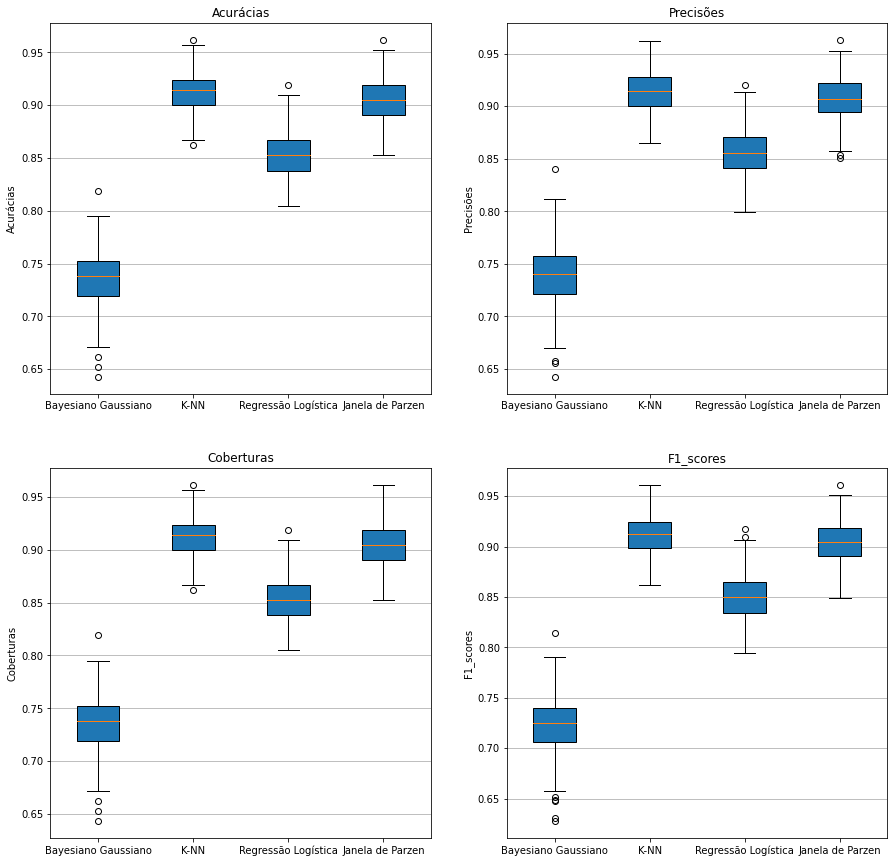

<Figure size 720x504 with 0 Axes>

In [369]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))
fig = plt.figure(figsize =(10, 7))
axs[0, 0].boxplot(accuracies,labels=["Bayesiano Gaussiano", "K-NN", "Regressão Logística","Janela de Parzen"],patch_artist=True)
axs[0, 0].set_title('Acurácias')
axs[0, 0].set( ylabel='Acurácias')
axs[0, 0].yaxis.grid(True)
axs[0, 0]
bplot1 = axs[0, 0]
axs[0, 1].boxplot(precisions,labels=["Bayesiano Gaussiano", "K-NN", "Regressão Logística","Janela de Parzen"],patch_artist=True)
axs[0, 1].set_title('Precisões')
axs[0, 1].set( ylabel='Precisões')
axs[0, 1].yaxis.grid(True)
bplot2 = axs[0, 1]
axs[1, 0].boxplot(recalls,labels=["Bayesiano Gaussiano", "K-NN", "Regressão Logística","Janela de Parzen"],patch_artist=True)
axs[1, 0].set_title('Coberturas')
axs[1, 0].set( ylabel='Coberturas')
axs[1, 0].yaxis.grid(True)
bplot3 = axs[1, 0]
axs[1, 1].boxplot(f1_scores,labels=["Bayesiano Gaussiano", "K-NN", "Regressão Logística","Janela de Parzen"],patch_artist=True)
axs[1, 1].set_title('F1_scores')
axs[1, 1].set( ylabel='F1_scores')
axs[1, 1].yaxis.grid(True)
bplot4 = axs[1, 1]

fig.savefig(fname="Boxplots",  facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

#for ax in axs.flat:
#    ax.set(xlabel='Modelos')